# FUGW Barycenter

In [21]:
import sys
if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install gdist

In [22]:
###########
# Imports #
###########
import jax
import gdist
import jax.numpy as jnp
import time as t
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from nilearn import datasets, image, plotting, surface
from ott.problems.quadratic import gw_barycenter as gwb
from ott.solvers.quadratic import gw_barycenter as gwb_solver

import warnings
warnings.filterwarnings("ignore")

#########
# Utils #
#########
def load_images_and_project_to_surface(image_paths):
    """Util function for loading and projecting volumetric images."""
    images = [image.load_img(img) for img in image_paths]
    surface_images = [
        jnp.nan_to_num(surface.vol_to_surf(img, fsaverage3.pial_left))
        for img in images
    ]

    return jnp.stack(surface_images).T

def load_surfacic_contrasts(cmaps, n_subjects):
    subject_list = [f"S0{i}" for i in range(n_subjects)]
    subjects_contrasts = {}

    for i, sub in enumerate(subject_list):
        image_paths = cmaps[i * len(contrasts) : (i + 1) * len(contrasts)]
        images = load_images_and_project_to_surface(image_paths)
        subjects_contrasts[sub] = images / jnp.max(images)

    return subjects_contrasts

def compute_geometry_from_mesh(mesh_path):
    """Util function to compute matrix of geodesic distances of a mesh."""
    (coordinates, triangles) = surface.load_surf_mesh(mesh_path)
    cost_matrix = gdist.local_gdist_matrix(
        coordinates.astype(jnp.float64), triangles.astype(jnp.int32)
    ).toarray()

    return cost_matrix
    

In [23]:
#################
# load subjects #
#################
n_subjects = 4

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]

cmaps = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
).cmaps

fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage3")

subjects_contrasts = load_surfacic_contrasts(cmaps, n_subjects)

##################
# plot subject 0 #
##################
contrast_idx = 1
surf_map = subjects_contrasts["S00"][:,contrast_idx]
plotting.view_surf(fsaverage3.pial_left, np.asarray(surf_map), cmap="coolwarm", title=contrasts[contrast_idx], threshold = 0.05 )

In [25]:
##############
# Parameters #
##############

# data
y_fused = jnp.vstack(subjects_contrasts.values())
cost_matrix = compute_geometry_from_mesh(fsaverage3.pial_left)
costs = jnp.repeat(cost_matrix[jnp.newaxis, ...], n_subjects, axis=0)
cost_matrix.shape

# dims
ndim = 3
ndim_f = len(contrasts)
n_points = cost_matrix.shape[0]
num_per_segment = [n_points] * n_subjects

# optimization
b = jnp.ones((n_subjects, n_points)) / n_points
fused_penalty = 0.5
epsilon = 1e-2
tau_a = 0.8
tau_b = 1.0
rank = 4

total time= 55.7s


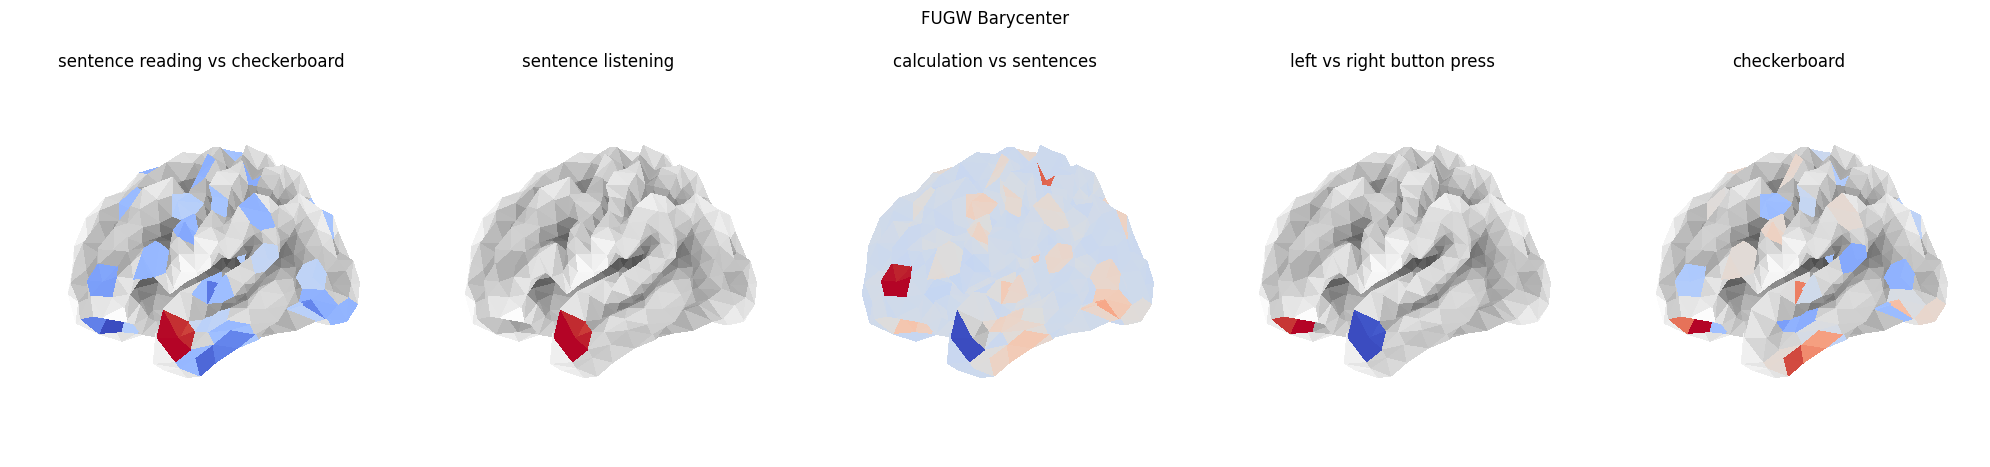

In [26]:
################
# optimization #
################
prob = gwb.GWBarycenterProblem(
    costs=costs,
    b=b,
    y_fused=y_fused,
    num_per_segment=num_per_segment,
    fused_penalty=fused_penalty,
    scale_cost="max_cost",
    tau_a=tau_a,
    tau_b=tau_b,
    gw_unbalanced_correction=True,
)

t1 = t.time()
solver = jax.jit(
    gwb_solver.GromovWassersteinBarycenter(epsilon=epsilon, rank=rank),
    static_argnames="bar_size",
)
fugw = solver(prob, bar_size=n_points)
print(f"total time={t.time() - t1 : .1f}s")

#########
# plots #
#########
fig = plt.figure(figsize=(20, 5))
fig.suptitle("FUGW Barycenter")
grid_spec = gridspec.GridSpec(1, 5, figure=fig)
for i, name in enumerate(contrasts):
    ax = fig.add_subplot(grid_spec[0, i], projection="3d")
    surf_map = fugw.x[:, i]
    ax.set_title(name)
    plotting.plot_surf(
        fsaverage3.pial_left,
        np.asarray(surf_map),
        bg_map=fsaverage3.sulc_left,
        axes=ax,
        colorbar=False,
        cmap="coolwarm",
        threshold = 0.05
    )
plt.tight_layout()